In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle
import warnings
from collections import namedtuple
from copy import copy
from glob import glob
from itertools import product
from os.path import join

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from aeff_calculations import (calc_aeff_factor, get_aeff_and_binnings,
                               get_energy_psf_grid)
from fluxes import (astro_flux, atmo_background, cut_off, parabola_index,
                    power_law)
from matplotlib.colors import LogNorm
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import *
from tools import array_source_interp, get_mids

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Settings

In [3]:
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube (10yr)",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + P-ONE (10yr)",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999", # seagreen-ish
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1 (10yr)",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000", # crimson-ish
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2 (10yr)",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}

In [4]:
# find the local path were non-git files are saved
savepath = "/".join(glob(BASEPATH + "/*/energy_smearing_rgi_up.pckl")[0].split("/")[:-1])
print(savepath)

/home/lisajsch/repos/Plenum/local


In [5]:
e_smearing_files = sorted(glob(join(savepath, "[!HE]*nergy_smearing_rgi_up.pckl")))
sigma5 = 1 - norm.cdf(5)
sigma3 = 1 - norm.cdf(3)
sigma1 = 1 - norm.cdf(1)

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [6]:
aeff_2d_base, logE_bins_old, _, sindec_bins_old, _ = get_aeff_and_binnings("upgoing")
logE_mids = get_mids(logE_bins_old)
sindec_mids = get_mids(sindec_bins_old)

# provide interpolation function for effective area
aeff_interp = {}
pad_logE = np.concatenate([[logE_bins_old[0]], logE_mids, [logE_bins_old[-1]]])
pad_sd = np.concatenate([[-1], sindec_mids, [1]])
for k in aeff_2d_base:
    aeff_interp[k] = RegularGridInterpolator(
        (pad_logE, pad_sd),
        np.pad(np.log(aeff_2d_base[k]), 1, mode="edge"),
    )

# set up new finer binning
logE_bins = np.linspace(2, 9, num=81)
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_bins = np.linspace(-1, 1, num=91)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
# make a baseline evaluation of the interpolation
aeff_2d = {}
ss, ll = np.meshgrid(sindec_mids, logE_mids)
for k in aeff_2d_base:
    aeff_2d[k] = np.exp(aeff_interp[k]((ll, ss)))

80 log_10(energy) bins
90 declination bins


# Background

In [7]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi_bg = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
# baseline evaluation
ss, em = np.meshgrid(sindec_mids, emids)
spl_vals = np.exp(rgi_bg((em, ss)))


# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [8]:
# energy smearing matrix
with open(join(BASEPATH, "local/energy_smearing_rgi_up.pckl"), "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 9.05, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
energy_resolution = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
energy_resolution = energy_resolution / np.sum(energy_resolution, axis=0)

# artificial, improved smearing matrix
with open(
    join(BASEPATH, "local/improved_0.5_artificial_energy_smearing_rgi_up.pckl"), "rb"
) as f:
    rgi = pickle.load(f)
improved_energy_resolution = rgi((lre_grid, lge_grid))
# normalize per bin in true energy
improved_energy_resolution = improved_energy_resolution / np.sum(
    improved_energy_resolution, axis=0
)


# PSF-Energy grid from the smearing matrix
$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$



Full 2D psi-energy LLH of sources around the horizon

NOTE: psi changes per detector over the day. Not yet implemented, effect probably negligible. We choose the horizontal resolution for all detectors

In [9]:
# psi² representation
delta_psi_max = 3
bins_per_psi2 = 25
all_grids, psi2_bins = get_energy_psf_grid(
    logE_mids, delta_psi_max=delta_psi_max, bins_per_psi2=bins_per_psi2
)
psi2_mids = get_mids(psi2_bins)

e_psi2_grid = all_grids['dec-0.0']
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl


# Flux definition

In [10]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 and TXS 0506+056 - source parameters

In [11]:
# 10yr PS PAPER PARAMETERS of NGC 1068
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 # @ 1 TeV / GeV cm² s
E0_NGC = 1E3

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(BASEPATH, "local/ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11
#gamma_c_68, phi_c_68 = np.loadtxt("../local/tenyr_paper_68_contour.txt")


# TXS parameters
with open(join(BASEPATH, "local/txs_contour.pkl"), "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = 2. #txs_contour["best-fit"][0]
PHI_TXS = 2.7E-20 #txs_contour["best-fit"][1] / 1E3 / 3 # fudge factor. # @ 1 TeV / GeV cm² s
E0_TXS = txs_contour["E0"] 

# parabola parameters
Alpha_TXS = 2
E_para_norm_TXS = 3E5
Beta_TXS = 1

# tmp_flux = LogP_flux(
#     PHI_TXS, Alpha_TXS, Beta_TXS, E_para_norm_TXS, "log-parabola"
# )

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")
txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")


In [12]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad

# ... with txs declination
txs_src_config = copy(src_config)
txs_src_config["dec"] = txs0506.dec.rad
txs_bg_config = copy(bg_config)
txs_bg_config["dec"] = txs0506.dec.rad


## Check event numbers

In [13]:
ident = "IceCube"  # "Plenum-2" #
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    normed_kvals=energy_resolution,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~80

## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **txs_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    normed_kvals=energy_resolution,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("txs 0506+056:", np.sum(k_s))  # ~5


ngc 1068: 84.41628431421012
txs 0506+056: 4.909020814406778


# Set up LLH function

In [14]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    verbose=False,
    emids=emids,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# Nominal PS fit

In [15]:
ident = "IceCube"
print(ident)

aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# asimov data
k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    spl_vals=array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids),
    normed_kvals=energy_resolution,
)
# power law
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=emids,
    normed_kvals=energy_resolution,
    phi_scaling=1,
    flux_shape=ngc_flux,  # powerlaw
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))


dct = dict(
    shape="powerlaw",
    mu_b_base=k_b,
    mu_s_base=aeff_factor_signal,
    k_i=k_i,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    normed_kvals=energy_resolution,
)

# fix signal normalization to 0
local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
global_llh = lambda x: ps_llh_2d_composite(x, **dct)

out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# this fit is not really needed, but good for crosschecking the code
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, ngc_flux.gamma),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


IceCube
Asimov data sum:
Background: 1154.8589647377719
Signal: 84.41628431421012
Atmo-only normalization: [1.07309038]
Signal fit parameters: [1.  1.  3.2]
TS check: -370082.92571623845 (fit:  -370082.92571623845 )
-2 Delta LLH: 20.347139101533685
P-VALUE: 3.816584505676276e-05 SIGNIFICANCE: 3.955634806850564


# Scan energy threshold
## Standard PS and energy spectrum

 cut on E_reco


In [16]:
## NGC 1068 and TXS 0506+056
# analysis region in distance to source
verbose = False
results = []
idents = ["IceCube", "Plenum-1", "Plenum-2"]
sources = ["ngc", "txs"]
enums = len(logE_reco_mids[logE_reco_mids<=5]) + 1

for i, ident, source in product(range(enums), idents, sources):
    if source == "ngc":
        src_coords = ngc1068
        src_flux = ngc_flux
    elif source == "txs":
        src_coords = txs0506
        src_flux = txs_flux

    # energy smearing
    energy_resolution_thresh = energy_resolution[i:]
    #energy_resolution_thresh /= np.sum(energy_resolution_thresh, axis=0)

    ## number of events
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)

    # asimov data
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        spl_vals=array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids),
        normed_kvals=energy_resolution_thresh,
    )
    # power law
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=emids,
        normed_kvals=energy_resolution_thresh,
        phi_scaling=1,
        flux_shape=src_flux,  # powerlaw
    )
    k_i = k_s + k_b

    dct = dict(
        shape="powerlaw",
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=src_flux.E0,
        phi_0=src_flux.norm,
        normed_kvals=energy_resolution_thresh,
        emids=emids,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, src_flux.gamma),
        approx_grad=True,
    )
    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    for out in [out_bckg, out_comp]:
        if out[2]["warnflag"] == 2:
            print("WARNING, bg failed")
            print(out)

    results.append(
        {
            r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$": logE_reco_mids[i],
            "ident": ident,
            "Detector": det_plotting[ident]["plainlabel"],
            "Source": source,
            "PL index": fr"$\gamma$ = {src_flux.gamma}",
            "p-value": pval,
            "Significance": significance,
            "n_s": np.sum(k_s),
            "n_b": np.sum(k_b),
        }
    )

    if verbose:
        print("Asimov data sum:")
        print("Background:", np.sum(k_b))
        print("Signal:", np.sum(k_s))
        print("Signal fit parameters:", out_comp[0])
        print(
            "TS check:", global_llh((1, 1, src_flux.gamma)), "(fit: ", out_comp[1], ")"
        )
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print("Atmo-only normalization:", out_bckg[0])
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        break

results = pd.DataFrame(results)
results.to_pickle(join(savepath, "ps_performance_e-thresh.pickle"))

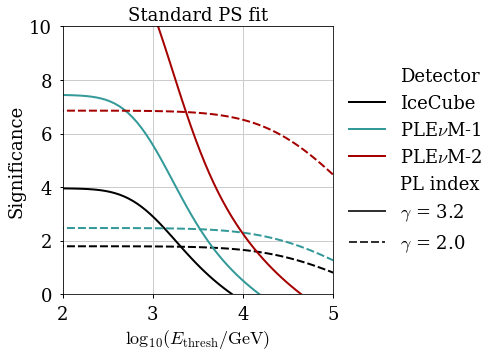

In [17]:
results = pd.read_pickle(join(savepath, "ps_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(7, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Detector",
    style="PL index",
    palette=[det_plotting[ident]["color"] for ident in idents],
)
ax.set_ylim(0, 10)
ax.set_xlim(2, 5)
ax.set_title("Standard PS fit")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
f.tight_layout()
f.savefig("../../plots/energy_threshold_significance_scan.pdf")


## NGC spectral shape + energy threshold

In [18]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
ident = "IceCube"
Gamma_cut = 2.0
logE_cut = 3.5 # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(
    PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)

## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        energy_resolution,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        energy_resolution,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut) ## should be ~0.97

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
     PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)

flux_scaling_cut 1.4271729213706608


In [19]:
## NGC 1068 and TXS 0506+056
# analysis region in distance to source
verbose = False
results = []
idents = ["IceCube", "Plenum-1", "Plenum-2"]
source = "ngc"
enums = len(logE_reco_mids[logE_reco_mids <= 5]) + 1

### using improved energy resolution ###

for i, ident in product(range(enums), idents):

    # energy smearing
    ### using improved energy resolution ###
    energy_resolution_thresh = improved_energy_resolution[i:]

    ## number of events
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)

    # asimov data
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        spl_vals=array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids),
        normed_kvals=energy_resolution_thresh,
    )
    # power law
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=emids,
        normed_kvals=energy_resolution_thresh,
        phi_scaling=1,
        flux_shape=ngc_cut_flux,  # powerlaw with cutoff
    )
    k_i = k_s + k_b

    dct = dict(
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        normed_kvals=energy_resolution_thresh,
        emids=emids,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw with cutoff", **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.2, 1.2, 3.0),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.2, 1.1, 1.9, 3.4),
        approx_grad=True,
    )
    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    for out in [out_bckg, out_comp]:
        if out[2]["warnflag"] == 2:
            print("WARNING, bg failed")
            print(out)

    results.append(
        {
            r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$": logE_reco_mids[i],
            "ident": ident,
            "Detector": det_plotting[ident]["plainlabel"],
            "Source": source,
            "p-value": pval,
            "Significance": significance,
            "n_s": np.sum(k_s),
            "n_b": np.sum(k_b),
            "Energy Reco": "50% improved",
        }
    )

    if verbose:
        print("Asimov data sum:")
        print("Background:", np.sum(k_b))
        print("Signal:", np.sum(k_s))
        print("Signal fit parameters:", out_comp[0])
        print(
            "TS check:", global_llh((1, 1, src_flux.gamma)), "(fit: ", out_comp[1], ")"
        )
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print("Atmo-only normalization:", out_bckg[0])
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        break

results = pd.DataFrame(results)
results.to_pickle(join(savepath, "ngc_performance_e-thresh.pickle"))

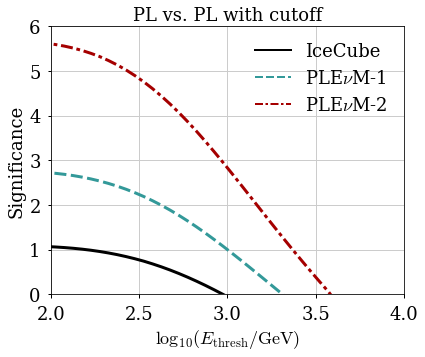

In [20]:
results = pd.read_pickle(join(savepath, "ngc_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Detector",
    style="Detector",
    palette=[det_plotting[ident]["color"] for ident in idents],
    lw=3,
    dashes=[
        "",
        (4, 1.5),
        (4, 1.25, 1.25, 1.25),
    ],
)
ax.set_ylim(0, 6)
ax.set_xlim(2, 4)
ax.set_title("PL vs. PL with cutoff")
ax.legend(loc=1, frameon=False)  # , bbox_to_anchor=(1, 0.5), frameon=False)
f.tight_layout()
f.savefig("../../plots/energy_threshold_significance_spectral_scan.pdf")


### combined plot

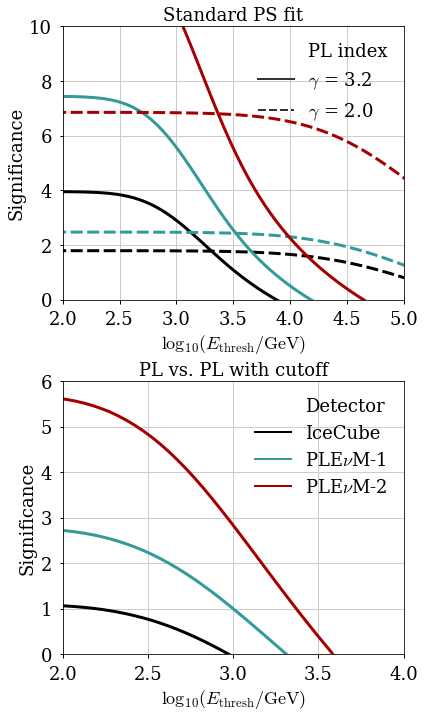

In [21]:
results = pd.read_pickle(join(savepath, "ps_performance_e-thresh.pickle"))
f, axes = plt.subplots(nrows=2, figsize=(6, 10))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Detector",
    style="PL index",
    palette=[det_plotting[ident]["color"] for ident in idents],
    ax=axes[0],
    lw=3,
)
ax.set_ylim(0, 10)
ax.set_xlim(2, 5)
ax.set_title("Standard PS fit")
h, l = ax.axes.get_legend_handles_labels()
ax.axes.legend_.remove()
ax.legend(h[-3:], l[-3:], frameon=False, loc=1)


results = pd.read_pickle(join(savepath, "ngc_performance_e-thresh.pickle"))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Detector",
    # style="Detector",
    palette=[det_plotting[ident]["color"] for ident in idents],
    lw=3,
    # dashes=[
    #     "",
    #     (4, 1.5),
    #     (4, 1.25, 1.25, 1.25),
    # ],
    ax=axes[1],
)
ax.set_ylim(0, 6)
ax.set_xlim(2, 4)
ax.set_title("PL vs. PL with cutoff")
ax.axes.legend_.remove()
ax.legend(
    h[:-3], l[:-3], loc=1, frameon=False
)  # , bbox_to_anchor=(1, 0.5), frameon=False)
f.tight_layout()
f.savefig("../../plots/energy_threshold_significance_spectral+PS_scan.pdf")


# NGC checks

Loop through parameters and check fit results

In [16]:
# cutoff parameters
Gamma_cuts = np.round(np.arange(1.6, 2.5, step=0.1), 2)
logE_cuts = np.round(np.arange(3, 4.1, step=0.1), 2)  # log10 (Ecut / GeV)
identifier = "Plenum-1"
nkv = improved_energy_resolution
es_ident = "improved"
pvals_ngc = []

for Gamma_cut, logE_cut in product(Gamma_cuts, logE_cuts):

    # define a temporary baseline flux for first fit iteration
    tmp_flux = PLcut_flux(PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff")

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[identifier], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[identifier], **ngc_src_config)

    ### scale the fluxes such that the event numbers match as first iteration
    astro_ev_sum_pl = np.sum(
        astro_flux(
            aeff_factor_signal,
            emids,
            energy_resolution,
            1,
            ngc_flux,
        )
    )

    # cutoff
    astro_ev_sum_cut = np.sum(
        astro_flux(
            aeff_factor_signal,
            emids,
            energy_resolution,
            1,
            tmp_flux,
        )
    )
    flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut

    # define the newly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
    )

    ## add IceCube to the other detector configs
    if identifier != "IceCube":
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids),
        normed_kvals=nkv,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        nkv,
        1,
        ngc_cut_flux_tmp,  # powerlaw with cutoff
    )

    k_i = k_s + k_b

    dct = dict(
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        normed_kvals=nkv,
    )
    pl_func = lambda x: ps_llh_2d_composite(
        x,
        shape="powerlaw",
        phi_0=ngc_flux.norm,  # normalized with PL baseline flux,
        **dct,
    )
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.0, 1.0, 3.0),
        approx_grad=True,
    )

    comp = lambda x: ps_llh_2d_composite(
        x,
        shape="powerlaw with cutoff",
        phi_0=ngc_cut_flux_tmp.norm,  # normalized with PL baseline flux,
        **dct,
    )
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1, 1, Gamma_cut, logE_cut),
        approx_grad=True,
    )

    # check the LLH at the "correct" parameter position
    check = comp((1, 1, Gamma_cut, logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    pvals_ngc.append(
        {
            "identifier": identifier,
            "e_smearing": es_ident,
            "pval": pval,
            "pval_check": pval_check,
            "significance": norm.isf(pval),
            "significance_check": norm.isf(pval_check),
            "gamma_cut": Gamma_cut,
            "logE_cut": logE_cut,
            "flux_scaling": flux_scaling_cut,
            "flux_cut_norm": PHI_NGC * flux_scaling_cut,
            "out_pl_gamma": out_bckg[0][2],
            "out_pl_norm": out_bckg[0][1],
            "out_plc_cut": out_comp[0][3],
            "out_plc_gamma": out_comp[0][2],
            "out_plc_norm": out_comp[0][1],
        }
    )
pvals_ngc = pd.DataFrame(pvals_ngc)
pd.to_pickle(pvals_ngc, join(BASEPATH, f"local/energy_cut_wiggle_{es_ident}_{identifier}.pckl"))


In [17]:
pvals_ngc = pd.read_pickle(join(BASEPATH, f"local/energy_cut_wiggle_improved_{identifier}.pckl"))
pvals_ngc["gamma_pl_diff"] = pvals_ngc.out_pl_gamma - GAMMA_NGC
pvals_ngc["norm_pl_diff"] = pvals_ngc.out_pl_norm - 1
pvals_ngc["pcheck_ratio"] = pvals_ngc.pval / pvals_ngc.pval_check

pivot_sigma = pvals_ngc.pivot("logE_cut", "gamma_cut", "significance")
pivot_gamma_diff = pvals_ngc.pivot("logE_cut", "gamma_cut", "gamma_pl_diff")
pivot_norm_diff = pvals_ngc.pivot("logE_cut", "gamma_cut", "norm_pl_diff")

## plotting

In [18]:
gamma_err = 0.2
norm_err = 0.2

In [37]:
sel = pivot_sigma[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

print(sel.to_latex(float_format="%.2f"))

sel = sel[sel.columns[np.abs(sel.columns - 2) <= 0.21]]
sel = sel.loc[
    sel.index <= 3.7
]

print(sel.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrrr}
\toprule
gamma\_cut &  1.6 &  1.7 &  1.8 &  1.9 &  2.0 &  2.1 &  2.2 &  2.3 &  2.4 \\
logE\_cut &      &      &      &      &      &      &      &      &      \\
\midrule
3.0      & 3.97 & 3.79 & 3.61 & 3.43 & 3.25 &  NaN &  NaN &  NaN &  NaN \\
3.1      & 4.19 & 4.00 & 3.80 & 3.61 & 3.41 & 3.21 & 3.01 &  NaN &  NaN \\
3.2      & 4.39 & 4.19 & 3.99 & 3.78 & 3.57 & 3.35 & 3.14 & 2.92 & 2.70 \\
3.3      & 4.57 & 4.37 & 4.15 & 3.94 & 3.71 & 3.49 & 3.26 & 3.03 & 2.79 \\
3.4      & 4.72 & 4.52 & 4.30 & 4.07 & 3.84 & 3.61 & 3.37 & 3.12 & 2.88 \\
3.5      &  NaN &  NaN & 4.41 & 4.19 & 3.95 & 3.71 & 3.46 & 3.20 & 2.94 \\
3.6      &  NaN &  NaN &  NaN &  NaN & 4.03 & 3.78 & 3.52 & 3.26 & 2.99 \\
3.7      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN & 3.56 & 3.29 & 3.02 \\
3.8      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN & 3.30 & 3.02 \\
3.9      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN & 3.00 \\
4.0      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN 

In [30]:
# select roughly matching results
pivot_sigma[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

# --> for gamma=2, ecut=3.5 yields the best separation,
# while still compatible within the IC error contour
# ecut=3.6 would also be OK, but the significance is not much larger than for 3.5
# but it is much less compatible with the IC results


gamma_cut,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4
logE_cut,,,,,,,,,
3.0,3.969469,3.791747,3.611485,3.429092,3.245005,NaN,NaN,NaN,NaN
3.1,4.185001,3.995461,3.802366,3.606263,3.407748,3.207464,3.006085,NaN,NaN
3.2,4.389146,4.190322,3.986529,3.778415,3.566718,3.352253,3.135903,2.918597,2.701295
3.3,4.571288,4.366310,4.154732,3.937238,3.714647,3.487905,3.258073,3.026305,2.793819
3.4,4.723294,4.515151,4.298776,4.074807,3.844072,3.607577,3.366504,3.122185,2.876074
3.5,NaN,NaN,4.413047,4.185232,3.949015,3.705389,3.455583,3.201047,2.943416
3.6,NaN,NaN,NaN,NaN,4.026663,3.777306,3.521144,3.258752,2.991884
3.7,NaN,NaN,NaN,NaN,NaN,NaN,3.560807,3.292664,3.018732
3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.301865,3.022582


In [29]:
pivot_gamma_diff[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

gamma_cut,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4
logE_cut,,,,,,,,,
3.0,0.080811,0.106654,0.133857,0.162364,0.192645,NaN,NaN,NaN,NaN
3.1,0.006258,0.031690,0.058558,0.086961,0.116922,0.148531,0.181796,NaN,NaN
3.2,-0.063222,-0.038199,-0.011601,0.016491,0.046293,0.077879,0.111342,0.146684,0.183904
3.3,-0.128268,-0.103531,-0.077281,-0.049367,-0.019684,0.011859,0.045363,0.080921,0.118659
3.4,-0.189366,-0.164934,-0.138735,-0.111097,-0.081497,-0.049978,-0.016349,0.019441,0.057527
3.5,NaN,NaN,-0.196972,-0.169239,-0.139549,-0.108028,-0.074262,-0.038159,0.000330
3.6,NaN,NaN,NaN,NaN,-0.199715,-0.162729,-0.128761,-0.092305,-0.053323
3.7,NaN,NaN,NaN,NaN,NaN,NaN,-0.180198,-0.143330,-0.103757
3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.193008,-0.151294


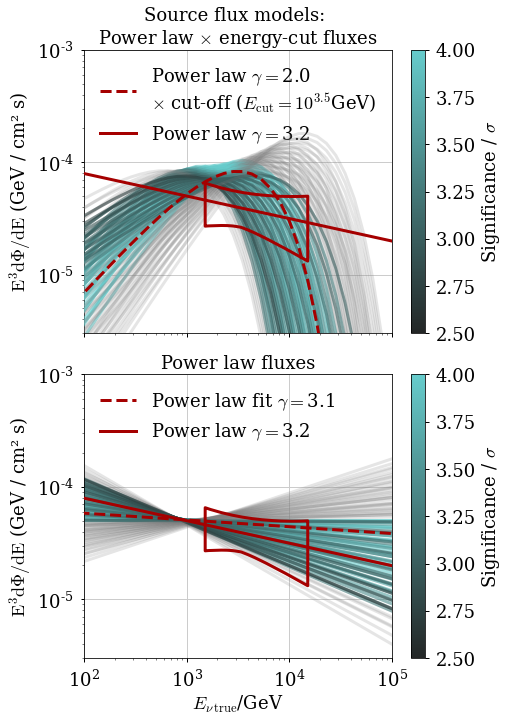

In [30]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 3

f, ax = plt.subplots(nrows=2, figsize=(7, 10), sharex=True)
ax[0].set_title("Source flux models: \n" + r"Power law $\times$ energy-cut fluxes")
ax[1].set_title("Power law fluxes")

cur_cmap = sns.dark_palette(det_plotting["P-ONE"]["color"], reverse=False, as_cmap=True)

sigma_min = 2.5  # np.min(pvals_ngc.significance) # 5  #
sigma_max = 4  # np.max(pvals_ngc.significance) # 7.5  #
color_projection = lambda x: cur_cmap((x - sigma_min) / (sigma_max - sigma_min))
sm = plt.cm.ScalarMappable(
    cmap=cur_cmap, norm=plt.Normalize(vmin=sigma_min, vmax=sigma_max)
)

for (Gamma_cut, logE_cut), series in pvals_ngc.groupby(["gamma_cut", "logE_cut"]):
    ## selecting results that are close to the original fit values
    mask = (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
    if mask[Gamma_cut].loc[logE_cut]:
        alpha_val = 0.6
        col = color_projection(series.iloc[0]["significance"])
    else:
        alpha_val = 0.2
        col = "gray"

    # define the correctly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        PHI_NGC * series.iloc[0]["flux_scaling"],
        Gamma_cut,
        logE_cut,
        E0_NGC,
        "powerlaw with cutoff",
    )
    cut = power_law(
        x_evals, ngc_cut_flux_tmp.E0, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux_tmp.e_cut)

    ax[0].plot(
        x_evals,
        cut * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=10,
        lw=3,
    )

    # define the correctly normalized PL flux for NGC 1068
    # using the parameters obtained when fitting the PL+cut flux with PL
    tmp_ngc_flux = PL_flux(
        PHI_NGC * series.iloc[0]["out_pl_norm"],
        series.iloc[0]["out_pl_gamma"],
        E0_NGC,
        "powerlaw",
    )

    pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

    ax[1].plot(
        x_evals,
        pl * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=1,
        lw=3,
    )
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

ax[0].plot(
    x_evals,
    cut * (x_evals**y_scaling),
    color=det_plotting["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law $\gamma=${ngc_cut_flux.gamma}"
    + "\n"
    + rf"$\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
)

# PL fit from chosen ecut/gamma parameters
selection = pvals_ngc.loc[
    (pvals_ngc.gamma_cut == ngc_cut_flux.gamma)
    & (pvals_ngc.logE_cut == ngc_cut_flux.e_cut)
]
tmp_ngc_flux = PL_flux(
    PHI_NGC * selection.iloc[0]["out_pl_norm"],
    selection.iloc[0]["out_pl_gamma"],
    E0_NGC,
    "powerlaw",
)

pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

ax[1].plot(
    x_evals,
    pl * (x_evals**y_scaling),
    color=det_plotting["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law fit $\gamma=${tmp_ngc_flux.gamma:1.1f}",
)


# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)


for axx in ax:
    axx.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        edgecolor=det_plotting["Plenum-2"]["color"],
        facecolor=(0, 0, 0, 0),
        lw=3,
        zorder=15,
    )
    axx.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${ngc_flux.gamma}",
        color=det_plotting["Plenum-2"]["color"],
        alpha=1,
        zorder=10,
        lw=3,
    )

    axx.set_yscale("log")
    axx.set_ylabel(rf"$\rm E^{{{y_scaling}}} d\Phi / dE$ (GeV / cm² s)")
    axx.set_xscale("log")
    if y_scaling == 3:
        axx.set_ylim(3e-6, 1e-3)
        axx.set_xlim(1e2, 1e5)
    elif y_scaling == 2:
        axx.set_ylim(1e-11, 1e-5)
        axx.set_xlim(1e2, 1e5)

    cb = plt.colorbar(sm, ax=axx)
    cb.set_label(r"Significance / $\sigma$")
    axx.legend(loc=2, frameon=False)
ax[1].set_xlabel(r"$E_{\nu \, \rm true}$/GeV")

f.tight_layout()
f.savefig(f"../../plots/pl-cut_flux_model_matching_E{y_scaling}.pdf")
